# Typical training data for ECG classifiers

## Notebook setup

In [22]:
import os
import configparser
from pathlib import Path
from typing import List, TypedDict

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#|include: false
# If the current working directory is the nbs/ folder, change to the project 
# root directory instead.

if Path.cwd().stem == "nbs":
    os.chdir(Path.cwd().parent)
print(f"The current working directory is {Path.cwd()}")

The current working directory is /Users/shaun/source/Thesis/PhysioNetChallenge2020


In [3]:
#|include: false
# Import configuration settings, like location of data directory.
config = configparser.ConfigParser()
if not Path("config.ini").exists():
    print("WARNING: Please generate a config.ini file by running scripts/get_datasets.py")
else:
    config.read("config.ini")
    data_dir = Path((config["datasets"]["path"])).expanduser()
    print(f"Datasets are located at {data_dir.resolve()}")

Datasets are located at /Users/shaun/source/Thesis/PhysioNetChallenge2020/data


## Dataset quickstart

***Table: Characteristics of 12-lead ECG recordings used for PhysioNet Challenge 2020***

| Dataset | Sampling frequency \[Hz\] | Recording length \[s\] | Notes |
|-|-|-|-|
| `cpsc`/`cpsc_extra` | 500 | 6 to 60 | Per HIPAA guidelines ages over 89 are removed |
| `incart` | 257 | 1800 | Holter recordings, annotations included |
| `ptb` | 1000 | ? |  |
| `ptbxl` | 500 | 10 |  |
| `georgia` | 500 | 10 | Southeastern US patient demographic |

Probably just use `ptbxl` and `georgia` for this project.


In [4]:
# Path to each training dataset

training_dir = data_dir / "challenge-2020" / "1.0.2" / "training"

georgia_dir = training_dir / "georgia"
cpsc_dir = training_dir / "cpsc_2018"
cpscextra_dir = training_dir / "cpsc_2018_extra"
ptb_dir = training_dir / "ptb"
ptbxl_dir = training_dir / "ptb-xl"
incart_dir = training_dir / "st_petersburg_incart"

`wfdb.rdheader` to read metadata about record.

`wfdb.rdrecord` to read signal data.

In [5]:
# record = wfdb.rdheader(georgia_dir / "g1" / "E00001")
# record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")

record = wfdb.rdrecord(ptbxl_dir / "g1" / "HR00001")

In [6]:
# Signal data as pandas dataframe
signals = record.to_dataframe()
signals.head()

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0 days 00:00:00,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.002000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.004000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.006000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075
0 days 00:00:00.008000,-0.115,-0.05,0.065,0.082,-0.09,0.007,-0.065,-0.04,-0.005,-0.035,-0.035,-0.075


In [7]:
# Each individual signal is a `Series` object
signals.I.head()

0 days 00:00:00          -0.115
0 days 00:00:00.002000   -0.115
0 days 00:00:00.004000   -0.115
0 days 00:00:00.006000   -0.115
0 days 00:00:00.008000   -0.115
Freq: 2ms, Name: I, dtype: float64

In [8]:
# Units for each channel (should all be in mV)
record.units

['mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv', 'mv']

In [9]:
# Sampling frequency (Hz)
record.fs

# If not 500 Hz, resample.
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html#resample-a-time-series-to-another-frequency

500

In [10]:
# Length of recording (should always be 10 s)
print(f"Length (s): {len(record.to_dataframe()) * (1/record.fs)}")

Length (s): 10.0


## Medical terminologies and codes

SNOMED-CT codes are provided as labels for each training dataset.

Dx stands for diagnosis?

In [11]:
record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")
record.comments # [2] is the diagnosis comment

['Age: 56',
 'Sex: Female',
 'Dx: 251146004,426783006',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

We could use a package such as [PyMedTermino2](https://owlready2.readthedocs.io/en/latest/pymedtermino2.html) to access medical terminologies from a UMLS database. 
However, we only need a very small subset of diagnosis codes. We'll just keep a 
Python dictionary of ~10 codes.

In [12]:
diagnosis_codes = {
    # Sinus rhythm
    426177001:  "Sinus bradycardia",
    426783006:  "Normal sinus rhythm",
    427084000:  "Sinus tachycardia",
    427393009:  "Sinus arrhythmia",

    # Conduction pathway (specifically right bundle branch)
    713427006:  "Complete right bundle branch block",
    713426002:  "Incomplete right bundle branch block",

    # T-wave (should be for each lead)
    164934002:  "T-wave abnormal",
    59931005:   "T-wave inversion",
}

In [13]:
def extract_snomed_ct_codes_from_comment(dx_comment: str) -> List[int]:
    """Returns a list of SNOMED-CT codes related to ECG diagnoses.

    Assumes that `dx_comment` is in the form "Dx: code1,code2,etc."

    Example usage:
    ```
    record = wfdb.rdheader(ptbxl_dir / "g1" / "HR00001")
    dx_comment = record.comments[2]
    dx_comment
    > 'Dx: 251146004,426783006'

    extract_snomed_ct_codes_from_comment(dx_comment)
    > [251146004, 426783006]
    ```
    """
    # Just the diagnosis codes (ignore the "Dx: " prefix)
    comment = dx_comment.split(': ')[1]

    # Split codes into list, convert to integers
    code_text = comment.split(',')
    return list(map(int, code_text))


In [14]:
# Example usage
extract_snomed_ct_codes_from_comment(record.comments[2])

[251146004, 426783006]

## Extract demographics and labels for population analysis

TODO.

Demographics: age, sex

Labels: subset of SNOMED-CT codes

In [15]:
def get_all_records(dataset_dir: Path) -> List[Path]:
    """Returns a list of every record in a PhysioNet Challenge 2020 dataset
    """
    records = []
    # For every folder (e.g. g1/, g2/, etc.)
    for folder in dataset_dir.iterdir():
        if folder.is_dir():
            # print(f"Searching folder: {folder}")
            # For every record (each record has a `.hea` header file)
            for file in folder.iterdir():
                if file.suffix == '.hea':
                    records.append( folder / file.stem )
    # print(f"Found {len(records)} records")
    return records

In [24]:
ptbxl_records = get_all_records(ptbxl_dir)
georgia_records = get_all_records(georgia_dir)

In [46]:
class DemographicInfo(TypedDict):
    age: int
    sex: str

def records_to_demographics_table(records: List[Path]) -> pd.DataFrame:
    data = []
    for record in records:
        header = wfdb.rdheader(record)

        # Extract demographic info
        age_str = header.comments[0].split(': ')[1]
        age = int( age_str ) if age_str.isnumeric() else None
        sex = header.comments[1].split(': ')[1]
        demographics: DemographicInfo = {
            'age': age,
            'sex': sex,
        }

        # Ignore obviously wrong ages
        if not age == None:
            if age > 150:
                continue

        data.append(demographics)

        # # Extract diagnostic info
        # diagnoses = extract_snomed_ct_codes_from_comment( header.comments[2] )
        # # TODO: save relevant ecg results as flags
    return pd.DataFrame(data)

In [48]:
ptbxl_df = records_to_demographics_table(ptbxl_records)

In [49]:
georgia_df = records_to_demographics_table(georgia_records)

### Data integrity issues

In [19]:
# Note: There seem to be errors in some of the comments. 
# Like this 300 year old lady.
header = wfdb.rdheader(ptbxl_records[248])
header.comments

['Age: 300',
 'Sex: Female',
 'Dx: 164873001,164934002,426783006',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

In [20]:
# Some records don't have an age recorded. Represented with "NaN".
header = wfdb.rdheader("data/challenge-2020/1.0.2/training/ptb-xl/g6/HR05040")
header.comments

['Age: NaN',
 'Sex: Female',
 'Dx: 39732003,426783006,429622005,445118002',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

In [21]:
# Some examples of NaN ages
ptbxl_df[ptbxl_df.age.isna()].head()

,age,sex
367,NaN,Female
511,NaN,Male
575,NaN,Female
656,NaN,Female
1003,NaN,Male


In [71]:
len(ptbxl_df[ptbxl_df.age.isna()])

89

In [72]:
len(georgia_df[georgia_df.age.isna()])

77

## Distributions

TODO: seaborn plot of age distribution. Also sex.

In [75]:
ptbxl_df.describe()

,age
count,21544.000000
mean,59.540754
std,16.757152
min,2.000000
25%,50.000000
50%,61.000000
75%,72.000000
max,89.000000


In [50]:
ptbxl_df.groupby("sex").describe()

# TODO: Remove paediatric cases. Either below 18 (UK) or below 21 (US).
# TODO: Remove obvious outlier ages. HIPAA guidelines say to remove ages over 89.

age                                                   
          count       mean        std  min   25%   50%   75%   max
sex                                                               
Female  10233.0  60.405942  18.026178  3.0  49.0  63.0  75.0  89.0
Male    11311.0  58.758023  15.479123  2.0  50.0  60.0  69.0  89.0

In [51]:
georgia_df.groupby("sex").describe()

age                                                    
         count       mean        std   min   25%   50%   75%   max
sex                                                               
Female  4750.0  60.280000  16.135244  20.0  50.0  62.0  72.0  89.0
Male    5517.0  60.664854  14.803825  14.0  52.0  62.0  71.0  89.0

Text(0.5, 1.0, 'Age distribution (georgia)')

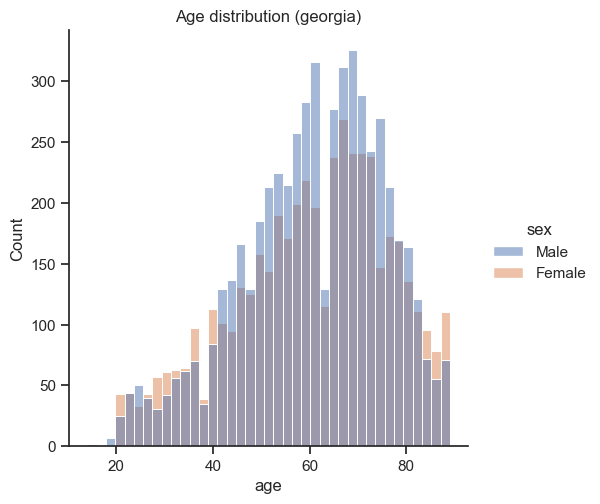

In [74]:
sns.set_theme(style="ticks")

sns.displot(georgia_df, x="age", hue="sex")
plt.title("Age distribution (georgia)")

Text(0.5, 1.0, 'Estimated PDF for georgia dataset')

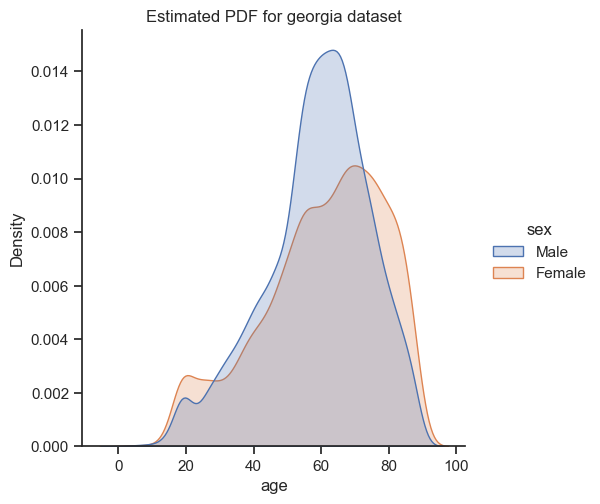

In [67]:
sns.set_theme(style="ticks")

sns.displot(ptbxl_df, x="age", hue="sex", kind="kde", fill=True, bw_adjust=1)
plt.title("Estimated PDF for georgia dataset")